In [1]:
#%matplotlib notebook

In [1]:
from scipy import *
from numpy import *
from scipy import optimize, stats
from matplotlib import pyplot as plt


In [2]:
def loadDatasets(lfn, disp=True):
    datasets=[loadtxt(fn) for fn in lfn]
    # Columns: frame, x, y, nan, intensity, ...

    if disp:
        fig,ax=plt.subplots(1,4,figsize=(12,2.5))

        plt.sca(ax[0])
        plt.ylim(0,8e5);
        plt.xlabel("Time (frame)"); plt.ylabel("Fluo. (a.u.)"); plt.title('Raw')
        plt.sca(ax[1]);
        plt.xlabel("x (px)"); plt.ylabel("y (px)"); plt.title('Centered')
        plt.gca().set_aspect('equal', 'datalim')
        plt.sca(ax[2]); plt.title('Centered')
        plt.xlabel("Time (frame)"); plt.ylabel("x (px)");
        plt.sca(ax[3]); plt.title('Centered')
        plt.xlabel("Time (frame)"); plt.ylabel("y (px)"); plt.gca().invert_yaxis()

        for d in datasets:
            ax[0].plot(d[:,0],d[:,4])
            #sel=where(d[:,4]>intensityCutoff)[0]
            #ax[1].plot(d[sel,1],d[sel,2])
            ax[1].plot(d[:,1]-mean(d[:,1]),d[:,2]-mean(d[:,2]))
            ax[2].plot(d[:,0],d[:,1]-mean(d[:,1]))
            ax[3].plot(d[:,0],d[:,2]-mean(d[:,2]))

        plt.tight_layout()
        plt.show()
    
    return datasets


In [3]:
def calcAndFitMSDs(datasets, iMax=20, weightMethod='sdOfCurves', disp=True, c=None):
    res=[]
    for d in datasets:
        mask=d[:,0]*0+1
        xy=d[:,1:3]
        res.append(array([
            #  Summed square displacement,                         Weight
            [  sum(((xy[i:]-xy[:-i]).T**2)*(mask[i:]*mask[:-i])),  sum(mask[i:]*mask[:-i])  ]
                                                   for i in range(1,iMax)]))

    msds=[c_[a[:,0]/a[:,1] *pxSize**2 ,a[:,1]] for a in res]
    yerr=var([a[:,0] for a in msds],0)**.5

    res=array(res).sum(0)
    msd=res[:,0]/res[:,1] *pxSize**2

    tau=r_[1:iMax] *dt

    if weightMethod=='sdOfCurves':
        fit, fitVar = optimize.curve_fit(lambda t,G : G*sqrt(t), tau, msd/2, sigma=yerr/2, p0=0.002)
    elif weightMethod=='nbPts':
        fit, fitVar = optimize.curve_fit(lambda t,G : G*sqrt(t), tau, msd/2, sigma=1/res[:,1], p0=0.002)
    elif weightMethod in ['none', 'None', None]:
        fit, fitVar = optimize.curve_fit(lambda t,G : G*sqrt(t), tau, msd/2, p0=0.002)
    else: raise ValueError('`weightMethod` paramter not understood.')
    #print("Fitted $\Gamma$ :", fit[0], "±", sqrt(fitVar[0, 0]))

    if disp:
        plt.figure(figsize=(3.5,2.7))
        #plt.figure(figsize=(4,3.5))
        for i,a in enumerate(msds): plt.plot(tau,a[:,0]/2,zorder=0,alpha=.4,c=None if c is None else c[i])
        plt.scatter(tau,msd/2,marker='o',ec='k',fc='w',lw=1.5)
        #plt.errorbar(tau,msd/2,yerr=yerr,marker='o',c='k',ls='')
        plt.plot(tau,fit*tau**.5, label='%d ± %d nm$^2/$s$^{1/2}$'%(fit[0]*1e6,fitVar[0,0]**.5*1e6),c='k', lw=1.5)
        plt.xscale('log'); plt.yscale('log')
        plt.xlabel('Time delay $\\tau$ (sec)'); plt.ylabel('$\\dfrac{{\\rm MSD}_{xy}(\\tau)}{2}$ ,  $\\mu m^2$')
        plt.legend()
        plt.tight_layout()
        #plt.show()
        plt.savefig('fig_MSDs.pdf')

    return fit, tau, msd, msds, yerr, res[:,1], fitVar


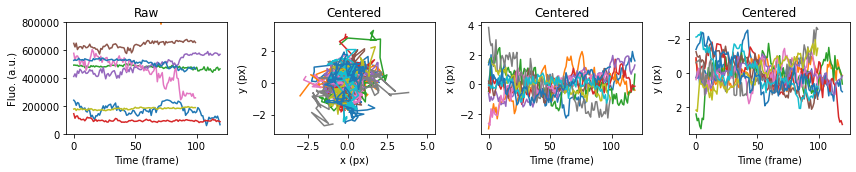

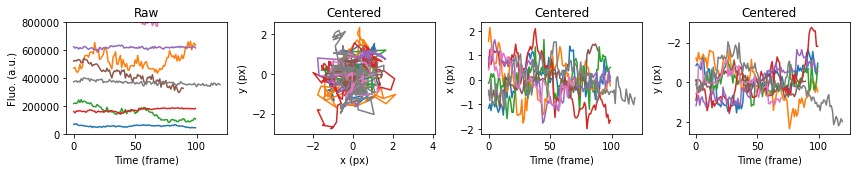

In [4]:
pxSize=0.129 # um
dt=5 # sec

dataPath='../../data/2-trajectory_files/noForce/'

lfn_preMSD=[  '20210723_Pos0_cell2_noForce-preExp.trk2',
              '20210723_Pos0_cell3_noForce-preExp.trk2',
              '20210723_Pos0_cell4_noForce-preExp.trk2',
              '20210723_Pos1_cell0_noForce-preExp.trk2',
              '20210723_Pos1_cell2_noForce-preExp.trk2',
              '20210723_Pos3_cell0_noForce-preExp.trk2',
              '20210723_Pos3_cell1_noForce-preExp.trk2',
              '20210723_Pos3_cell2_noForce-preExp.trk2',
              '20210723_Pos4_cell0_noForce-preExp.trk2',
              '20210723_Pos4_cell1_noForce-preExp.trk2',
              '20210723_Pos8_cell0_noForce-preExp.trk2',
           ]
preMSD=loadDatasets([dataPath+f for f in lfn_preMSD])


lfn_postMSD=[ '20210723_Pos0_cell0_noForce-postExp.trk2',
              '20210723_Pos0_cell3_noForce-postExp.trk2',
              '20210723_Pos0_cell4_noForce-postExp.trk2',
              '20210723_Pos1_cell0_noForce-postExp.trk2',
              '20210723_Pos3_cell0_noForce-postExp.trk2',
              '20210723_Pos3_cell2_noForce-postExp.trk2',
              '20210723_Pos4_cell1_noForce-postExp.trk2',
              '20210723_Pos8_cell0_noForce-postExp.trk2',
            ]
postMSD=loadDatasets([dataPath+f for f in lfn_postMSD])


(793.4313212123811, 0.400925377065377)

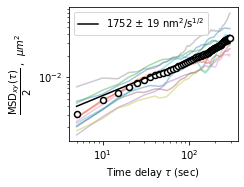

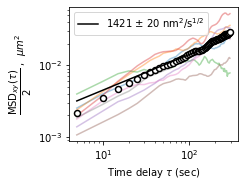

In [5]:
preMSD_fit =calcAndFitMSDs(preMSD, iMax=60)[0]
postMSD_fit=calcAndFitMSDs(postMSD,iMax=60)[0]

mean(r_[preMSD_fit,postMSD_fit])/2*1e6, mean(r_[preMSD_fit,postMSD_fit])/2*1e6/1979


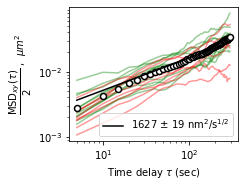

In [6]:
allMSD_fit=calcAndFitMSDs(preMSD+postMSD, iMax=60, c=['g']*len(preMSD)+['r']*len(postMSD))[0]


20210723_Pos0_cell3
20210723_Pos0_cell4
20210723_Pos1_cell0
20210723_Pos3_cell0
20210723_Pos3_cell2
20210723_Pos4_cell1
20210723_Pos8_cell0


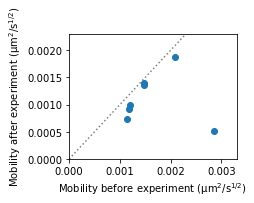

In [7]:
lfnPaired=[
    ['20210723_Pos0_cell3_noForce-preExp.trk2',
     '20210723_Pos0_cell3_noForce-postExp.trk2',],
    ['20210723_Pos0_cell4_noForce-preExp.trk2',
     '20210723_Pos0_cell4_noForce-postExp.trk2',],
    ['20210723_Pos1_cell0_noForce-preExp.trk2',
     '20210723_Pos1_cell0_noForce-postExp.trk2',],
    ['20210723_Pos3_cell0_noForce-preExp.trk2',
     '20210723_Pos3_cell0_noForce-postExp.trk2',],
    ['20210723_Pos3_cell2_noForce-preExp.trk2',
     '20210723_Pos3_cell2_noForce-postExp.trk2',],
    ['20210723_Pos4_cell1_noForce-preExp.trk2',
     '20210723_Pos4_cell1_noForce-postExp.trk2',],
    ['20210723_Pos8_cell0_noForce-preExp.trk2',
     '20210723_Pos8_cell0_noForce-postExp.trk2',],]

fnPair=lfnPaired[0]; res=[]
for fnPair in lfnPaired:
    print(fnPair[0].split('_noForce')[0])
    ds=loadDatasets([dataPath+f for f in fnPair],disp=0)
    fit,tau,msd,msds=calcAndFitMSDs(ds, iMax=20, disp=0)[:4]
    res.append((c_[msds[0][:,0]/2,msds[1][:,0]/2].T/tau**.5).T[:4].mean(0))
    #res.append([calcAndFitMSDs([ds[0]], iMax=2, weightMethod=None, disp=0),
    #            calcAndFitMSDs([ds[1]], iMax=2, weightMethod=None, disp=0)])

res=array(res)


plt.figure(figsize=(3.,2.3))
plt.scatter(res[:,0],res[:,1])
x=r_[0,.01]; plt.plot(x,x, c='gray', ls=':', zorder=0)
plt.xlim(0,.0033); plt.ylim(0,.0023);#plt.xscale('log'); plt.yscale('log'); plt.xlim(.007,.03); plt.ylim(.003,.02);
plt.xlabel('Mobility before experiment (µm$^2$/s$^{1/2}$)'); plt.ylabel('Mobility after experiment (µm$^2$/s$^{1/2}$)');
plt.savefig('fig_MSDs_beforeAfter.pdf')


In [8]:
stats.wilcoxon(diff(res,1)[:,0])

WilcoxonResult(statistic=0.0, pvalue=0.015625)

20210723_Pos0_cell2
20210723_Pos0_cell3
20210723_Pos0_cell4
20210723_Pos1_cell0
20210723_Pos1_cell2
20210723_Pos3_cell0
20210723_Pos3_cell1
20210723_Pos3_cell2
20210723_Pos4_cell0
20210723_Pos4_cell1
20210723_Pos8_cell0


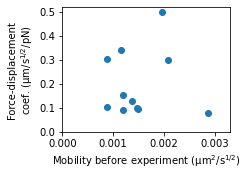

In [9]:
lfn_PR=[
  '20210723_Pos0_cell0',
  '20210723_Pos0_cell2',
  '20210723_Pos0_cell3',
  '20210723_Pos0_cell4',
  '20210723_Pos1_cell0',
  '20210723_Pos1_cell2',
  '20210723_Pos3_cell0',
  '20210723_Pos3_cell1',
  '20210723_Pos3_cell2',
  '20210723_Pos4_cell0',
  '20210723_Pos4_cell1',
  '20210723_Pos8_cell0']

#       Force, displ. 5' (from 'fig2_...' notebook)
force_displ=array([
       [0.16178537, 0.95457928],
       [0.20625558, 1.78374971],
       [1.60490185, 2.61829229],
       [0.24479624, 1.27493086],
       [0.79115025, 1.39194541],
       [0.46308993, 0.82597098],
       [0.97882067, 5.7896392 ],
       [0.22835004, 0.50618512],
       [0.3315813 , 0.45450655],
       [0.15341437, 0.80716032],
       [1.00913104, 2.69003036],
       [0.66075942, 1.03421415]])


res=[]
for i0 in range(len(lfn_PR)):
    for i1 in range(len(lfn_preMSD)):
        if lfn_PR[i0]==lfn_preMSD[i1][:19]:
            fn=lfn_preMSD[i1]
            print(fn[:19])
            fit,tau,msd=calcAndFitMSDs(loadDatasets([dataPath+fn],disp=0), iMax=20, weightMethod=None, disp=0)[:3]
            res.append([(msd/2/tau**.5)[:4].mean(),
            #res.append([fit,
                        force_displ[i0][1]/(5*60)**.5/force_displ[i0][0]])
            break
        
res=array(res)

plt.figure(figsize=(3.,2.3))
plt.scatter(res[:,0],res[:,1])
plt.xlim(0,.0033); plt.ylim(0,None);
plt.xlabel('Mobility before experiment (µm$^2$/s$^{1/2}$)'); plt.ylabel('Force-displacement\ncoef. (µm/s$^{1/2}$/pN)');

plt.savefig('fig_MSDs_vsForceDispl.pdf')


In [10]:
stats.spearmanr(res[:,0],res[:,1])

SpearmanrResult(correlation=-0.23636363636363636, pvalue=0.4840911622253965)